In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

In [2]:
from ipynb.fs.defs.census_and_restaurant_data_withEDA import adjoin_census

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from tree_helpers import SkNode, create_sk_nodes
from sklearn.metrics import precision_score, recall_score

from cluster_fns import get_errs, assign_class, LE_Class, get_subsets, def_cluster, deconstruct, good_rmse, bad_rmse, DecCluster

Let's get the dataset.

In [3]:
df = pd.read_csv("/Users/dominiquekemp/Documents/GitHub/'Will It Restaurant?'/train_data_with_census.csv")

#add on census data
census_data = pd.read_csv("/Users/dominiquekemp/Documents/GitHub/'Will It Restaurant?'/census_data.csv")

df = adjoin_census(df, census_data)

In [4]:
df

,name,site,subtypes,category,type,phone,full_address,borough,street,postal_code,...,% White,% Black,% Asian,% Hispanic/Latino,Foreign Born Immigrant %,Median Age,Neighborhood Turnover %,state,county,tract
0,The Legends of Seafood and Soul Food,True,"Seafood restaurant, Soul food restaurant",restaurants,Seafood restaurant,True,"5352 Woodland Ave, Philadelphia, PA 19143",Kingsessing,5352 Woodland Ave,19143.0,...,0.008011,0.952486,0.000000,0.024862,0.107459,36.3,0.000000,42,101,7000
1,Fette Sau,True,"Restaurant, American restaurant, Barbecue rest...",restaurants,Restaurant,True,"1208 Frankford Ave, Philadelphia, PA 19125",Fishtown,1208 Frankford Ave,19125.0,...,0.651473,0.096267,0.068566,0.246955,0.109430,31.5,0.003249,42,101,14400
2,Cafe Liz,False,"Portuguese restaurant, Bar",restaurants,Portuguese restaurant,True,"5437 N Lawrence St, Philadelphia, PA 19120",Olney-Oak Lane,5437 N Lawrence St,19120.0,...,0.051712,0.571741,0.250910,0.153314,0.322651,46.9,0.000000,42,101,27401
3,Plaza Pizza and Grill,True,"Pizza restaurant, Breakfast restaurant, Cheese...",restaurants,Pizza restaurant,True,"1614 Cecil B. Moore Ave, Philadelphia, PA 19121",North Philadelphia,1614 Cecil B. Moore Ave,19121.0,...,0.360881,0.452905,0.066041,0.093107,0.075424,22.0,0.000000,42,101,14700
4,Little Fish BYOB,True,Seafood restaurant,restaurants,Seafood restaurant,True,"746 S 6th St, Philadelphia, PA 19147",Bella Vista,746 S 6th St,19147.0,...,0.758715,0.148530,0.049409,0.013640,0.064262,34.9,0.002475,42,101,1800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2383,China House,False,"Chinese restaurant, Delivery Restaurant",restaurants,Chinese restaurant,True,"2015, 7141 Ogontz Ave, Philadelphia, PA 19138",Olney-Oak Lane,"2015, 7141 Ogontz Ave",19138.0,...,0.005266,0.955822,0.000000,0.013019,0.075336,40.8,0.000000,42,101,26600
2384,Sabrina's Cafe,True,"Restaurant, Breakfast restaurant, Brunch resta...",restaurants,Restaurant,True,"1804 Callowhill St, Philadelphia, PA 19130",Center City,1804 Callowhill St,19130.0,...,0.681634,0.081147,0.194482,0.067081,0.247227,32.7,0.021573,42,101,12502
2385,Dagwood's Pub,True,Bar & grill,restaurants,Bar & grill,True,"4625 Linden Ave, Philadelphia, PA 19114",Northeast Philadelphia,4625 Linden Ave,19114.0,...,0.881232,0.042764,0.052898,0.054722,0.067694,48.3,0.000000,42,101,35200
2386,Malooga,True,"Middle Eastern restaurant, Falafel restaurant,...",restaurants,Middle Eastern restaurant,True,"134 Chestnut St, Philadelphia, PA 19106",Center City East,134 Chestnut St,19106.0,...,0.868400,0.008394,0.090171,0.017601,0.176279,45.5,0.000000,42,101,1002


It is the objective of this notebook to attempt deconstruction one more time for another borough not amenable to any of our previous methods.

In [5]:
ne_ph = df[df.borough == "Northeast Philadelphia"]

In [6]:
print(f"We only lost {373 - len(ne_ph)} restaurants from the 'adjoin_census' operation.")

We only lost 5 restaurants from the 'adjoin_census' operation.


In [7]:
ne_ph.range.value_counts()

range
1    179
2    151
0     37
3      1
Name: count, dtype: int64

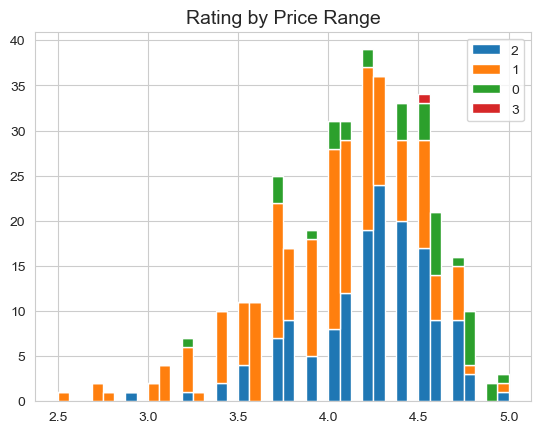

In [8]:
#distribution of ratings stacked by price range
fig, ax = plt.subplots()

ax.hist([ne_ph[ne_ph.range == p].rating for p in ne_ph.range.unique()], bins = 40, stacked = True, label = ne_ph.range.unique())

ax.legend()
ax.set_title('Rating by Price Range', fontsize = 14)
plt.show()

In [9]:
ne_ph[ne_ph.range == '0'].rating.describe()

count    37.000000
mean      4.402703
std       0.412638
min       3.200000
25%       4.100000
50%       4.500000
75%       4.700000
max       5.000000
Name: rating, dtype: float64

Again, there is stark difference in the histograms across the various price levels. In particular, level 1 takes on the lowest ratings and is slightly more skewed towards them, compared to the distribution of level 2 ratings. There are not many level 0 restaurants, and their ratings are mainly packed between 4.1 and 5.0. So, 'k-neighbors' regression may be reasonably effective here, merely from a probabilistic point of view.

In [10]:
#make a kfold object (necessary for DecCluster)
n_splits = 5
skfold = StratifiedKFold(n_splits, random_state= 5501, shuffle = True)
kfold = KFold(n_splits, random_state = 5501, shuffle = True)

#make DecCluster object with stratified kfold
s_dc = DecCluster(skfold)

Recall that the best model we have for level 1 NE Philly restaurants is k-neighbors regression with geospatial and interaction features, as well as cuisine specificity.

### Analysis of Level 1 Restaurants for NE Philly

In [11]:
#obtain the dataset
df_one = df[df.range == '1']
class_feats = ['latitude', 'longitude', 'reviews', 'photos_count'] + df_one.columns[-14:-3].tolist() #add the census features too
df_one = pd.concat([df_one, pd.get_dummies(df_one.type)], axis = 1)


class_feats = class_feats + df_one.columns[-91:].tolist() #include cuisine types

mod_feats = class_feats[:4] + class_feats[-91:] #specify features to use for the (initial) model

#best model found previously for NE Philly level 1
knn_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsRegressor(6))])
#fit DecCluster object
s_dc.fit(df_one, "Northeast Philadelphia", knn_pipe, mod_feats, class_feats, thresh = 0.4)

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/dominiquekemp/Documents/GitHub/'Will It Restaurant?'/cluster_fns.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[indices, 'Errors'] = errs
/Users/dominiquekemp/Documents/GitHub/'Will It Restaurant?'/cluster_fns.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cla

In [12]:
print("The deconstruction scheme on price level 1 restaurants modeled by 6-neighbors regression, the best model we have so far (with CV RMSE value 0.411) is:")
print(" ")
print(f'Precision score: {s_dc.prec}')
print(f"Recall score: {s_dc.recall}")
print("The table of feature importances is: ")
print(s_dc.feat_imp.head(10))
print(" ")
print(f"We recover improvement of the RMSE to {s_dc.good_rmse} on the good set, and the error worsens to {s_dc.bad_rmse} on the bad set.")
print(f"The size of the bad set is {len(s_dc.err_df)}.")

The deconstruction scheme on price level 1 restaurants modeled by 6-neighbors regression, the best model we have so far (with CV RMSE value 0.411) is:
 
Precision score: 0.8421
Recall score: 0.6275
The table of feature importances is: 
                    features  importance score
3               photos_count          0.240131
1                  longitude          0.144201
6          Education Level %          0.113270
5             Poverty Rate %          0.098741
2                    reviews          0.067883
12  Foreign Born Immigrant %          0.056725
88                Restaurant          0.052071
9                    % Black          0.047057
0                   latitude          0.041425
11         % Hispanic/Latino          0.037629
 
We recover improvement of the RMSE to 0.29614345447177715 on the good set, and the error worsens to 0.7178336072651504 on the bad set.
The size of the bad set is 38.


In [13]:
bad = s_dc.err_df

Let's test some models on the 'bad' subset. Informed by the table of feature importances above, we select the features we shall use.

In [14]:
feats = ['photos_count', 'longitude', 'Education Level %', 'Poverty Rate %', 'reviews', 'Foreign Born Immigrant %', 'Restaurant']

ne_one = df_one[df_one.borough == 'Northeast Philadelphia']

In [15]:
n_splits = 5
num_k = 18

rmses = np.zeros((num_k, n_splits))

for k in range(num_k):
    i = 0
    for train, test in kfold.split(bad):
        bad_train = bad.iloc[train]
        bad_test = bad.iloc[test]
        knn_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsRegressor(k+1))])

        knn_pipe.fit(bad_train[feats], bad_train.rating)
        preds = knn_pipe.predict(bad_test[feats ])

        rmses[k, i] = root_mean_squared_error(bad_test.rating, preds)
        i += 1
rmses = np.mean(rmses, axis = 1)
min_k = np.argmin(rmses)
print(f'The best RMSE value is {rmses[min_k]: .3f}, happening at k = {min_k + 1}.')
    

The best RMSE value is  0.626, happening at k = 4.


In [16]:
rf_b = RandomForestRegressor(max_depth = 5, random_state= 50492, max_features= len(feats))

rmses = np.zeros(n_splits)

i=0
for train, test in kfold.split(bad):
    bad_train = bad.iloc[train]
    bad_test = bad.iloc[test]

    rf_b.fit(bad_train[feats], bad_train.rating)
    preds = rf_b.predict(bad_test[feats])

    rmses[i] = root_mean_squared_error(bad_test.rating, preds)
    i += 1
rmses = np.mean(rmses)
print(f'The RMSE value is {rmses: .3f}.')

score_df = pd.DataFrame({'feature': feats,
                           'importance_score': rf_b.feature_importances_})
score_df.sort_values('importance_score', ascending = False, inplace = True)
score_df.head(10)

The RMSE value is  0.610.


,feature,importance_score
5,Foreign Born Immigrant %,0.371275
4,reviews,0.216054
0,photos_count,0.166221
1,longitude,0.104514
2,Education Level %,0.080203
3,Poverty Rate %,0.038290
6,Restaurant,0.023442


In [70]:
feats

['photos_count',
 'longitude',
 'Education Level %',
 'Poverty Rate %',
 'reviews',
 'Foreign Born Immigrant %',
 'Restaurant']

In [17]:

mlr = LinearRegression()

rmses = np.zeros( n_splits)

i = 0
for train, test in kfold.split(bad):
    bad_train = bad.iloc[train]
    bad_test = bad.iloc[test]
  
    mlr.fit(bad_train[feats], bad_train.rating)
    preds = mlr.predict(bad_test[feats])
    for j in range(len(preds)):
        value = preds[j]
        if value >= 5.0:
            preds[j] = 5.0

    rmses[i] = root_mean_squared_error(bad_test.rating, preds)
    i += 1
rmses = np.mean(rmses)

print(f'The RMSE value is {rmses: .3f}.')
    

The RMSE value is  0.738.


We are again seeing very limited improvement. Let us try, as before, random forest regression with features selected from all features presented except cuisine types.

In [18]:
all_feats = class_feats[:-91]

rf_b = RandomForestRegressor(max_depth = 5, random_state= 50492, max_features= len(all_feats))

rmses = np.zeros(n_splits)

i=0
for train, test in kfold.split(bad):
    bad_train = bad.iloc[train]
    bad_test = bad.iloc[test]

    rf_b.fit(bad_train[all_feats], bad_train.rating)
    preds = rf_b.predict(bad_test[all_feats])

    rmses[i] = root_mean_squared_error(bad_test.rating, preds)
    i += 1
rmses = np.mean(rmses)
print(f'The RMSE value is {rmses: .3f}.')

score_df = pd.DataFrame({'feature': all_feats,
                           'importance_score': rf_b.feature_importances_})
score_df.sort_values('importance_score', ascending = False, inplace = True)
score_df.head(10)



The RMSE value is  0.610.


,feature,importance_score
12,Foreign Born Immigrant %,0.248568
2,reviews,0.181845
14,Neighborhood Turnover %,0.166922
3,photos_count,0.157635
1,longitude,0.053637
6,Education Level %,0.038119
0,latitude,0.031044
4,Median Household Income,0.027425
7,Total Population,0.027140
11,% Hispanic/Latino,0.019766


In [19]:
#select the most significant features from the above table 
feats = ['Foreign Born Immigrant %', 'reviews', 'Neighborhood Turnover %', 'photos_count', 'longitude']

In [24]:

mlr = LinearRegression()

rmses = np.zeros( n_splits)

i = 0
for train, test in kfold.split(bad):
    bad_train = bad.iloc[train]
    bad_test = bad.iloc[test]
  
    mlr.fit(bad_train[feats[:-2]], bad_train.rating)
    preds = mlr.predict(bad_test[feats[:-2]])
    for j in range(len(preds)):
        value = preds[j]
        if value >= 5.0:
            preds[j] = 5.0

    rmses[i] = root_mean_squared_error(bad_test.rating, preds)
    i += 1
rmses = np.mean(rmses)

print(f'The RMSE value is {rmses: .3f}.')
    

The RMSE value is  0.682.


In [21]:
rf_b = RandomForestRegressor(max_depth = 5, random_state= 50492, max_features= len(feats))

rmses = np.zeros(n_splits)

i=0
for train, test in kfold.split(bad):
    bad_train = bad.iloc[train]
    bad_test = bad.iloc[test]

    rf_b.fit(bad_train[feats[:-1]], bad_train.rating)
    preds = rf_b.predict(bad_test[feats[:-1]])

    rmses[i] = root_mean_squared_error(bad_test.rating, preds)
    i += 1
rmses = np.mean(rmses)
print(f'The RMSE value is {rmses: .3f}.')


The RMSE value is  0.561.


In [22]:
n_splits = 5
num_k = 18

rmses = np.zeros((num_k, n_splits))

for k in range(num_k):
    i = 0
    for train, test in kfold.split(bad):
        bad_train = bad.iloc[train]
        bad_test = bad.iloc[test]
        knn_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsRegressor(k+1))])

        knn_pipe.fit(bad_train[feats[:-1]], bad_train.rating)
        preds = knn_pipe.predict(bad_test[feats[:-1] ])

        rmses[k, i] = root_mean_squared_error(bad_test.rating, preds)
        i += 1
rmses = np.mean(rmses, axis = 1)
min_k = np.argmin(rmses)
print(f'The best RMSE value is {rmses[min_k]: .3f}, happening at k = {min_k + 1}.')
    

The best RMSE value is  0.544, happening at k = 5.


In [25]:
feats = ['Foreign Born Immigrant %', 'reviews', 'Neighborhood Turnover %', 'photos_count']

The best model on the bad set is 5-neighbors regression with 'Foreign Born Immigrant %', 'reviews', 'Neighborhood Turnover %', 'photos_count' features. The CV RMSE is reduced to 0.544 here, a reduction of nearly 0.18.

In [26]:
bad.sample(5)

,name,site,subtypes,category,type,phone,full_address,borough,street,postal_code,...,Takeout Restaurant,Tex-Mex restaurant,Thai restaurant,Traditional American restaurant,Vegan restaurant,Vegetarian restaurant,Vietnamese restaurant,West African restaurant,Errors,Class
1091,Tiffany On The BLVD,False,"Restaurant, Banquet hall, Bar, Breakfast resta...",restaurants,Restaurant,True,"9010 Roosevelt Blvd, Philadelphia, PA 19115",Northeast Philadelphia,9010 Roosevelt Blvd,19115.0,...,False,False,False,False,False,False,False,False,0.233333,0
1963,Registon restaurant,False,"Restaurant, Delivery Restaurant",restaurants,Restaurant,True,"724 Red Lion Rd, Philadelphia, PA 19115",Northeast Philadelphia,724 Red Lion Rd,19115.0,...,False,False,False,False,False,False,False,False,0.416667,1
105,Mario Brothers Pizza,True,"Pizza restaurant, Italian restaurant, Delivery...",restaurants,Pizza restaurant,True,"2224 Cottman Ave, Philadelphia, PA 19149",Northeast Philadelphia,2224 Cottman Ave,19149.0,...,False,False,False,False,False,False,False,False,0.466667,1
1943,KFC,True,"Chicken restaurant, Fast food restaurant",restaurants,Chicken restaurant,True,"6417 Harbison Ave, Philadelphia, PA 19149",Northeast Philadelphia,6417 Harbison Ave,19149.0,...,False,False,False,False,False,False,False,False,0.533333,1
741,Reen's Delicatessen,True,"Restaurant, Breakfast restaurant, Cold cut sto...",Deli,Restaurant,True,"12319 Academy Rd, Philadelphia, PA 19154",Northeast Philadelphia,12319 Academy Rd,19154.0,...,False,False,False,False,False,False,False,False,0.700000,1


### Analysis of Level 2-3 Restaurants

In [27]:
all_feats = class_feats[:-91]

df_two = df[(df.range == '2') | (df.range == '3')]
ne_two = df_two[df_two.borough == 'Northeast Philadelphia']

In [28]:
all_feats = all_feats + ne_two.type.unique().tolist()

In [29]:
all_feats

['latitude',
 'longitude',
 'reviews',
 'photos_count',
 'Median Household Income',
 'Poverty Rate %',
 'Education Level %',
 'Total Population',
 '% White',
 '% Black',
 '% Asian',
 '% Hispanic/Latino',
 'Foreign Born Immigrant %',
 'Median Age',
 'Neighborhood Turnover %',
 'Indian restaurant',
 'Kosher restaurant',
 'Mexican restaurant',
 'Pizza restaurant',
 'Salvadoran restaurant',
 'Italian restaurant',
 'Restaurant',
 'Seafood restaurant',
 'Chinese restaurant',
 'Brazilian restaurant',
 'Portuguese restaurant',
 'Korean restaurant',
 'Bar & grill',
 'West African restaurant',
 'Japanese restaurant',
 'Sandwich shop',
 'Asian fusion restaurant',
 'Ramen restaurant',
 'Health food restaurant',
 'Beer garden',
 'Chicken wings restaurant',
 'Dim sum restaurant',
 'Cajun restaurant',
 'American restaurant',
 'Cheesesteak restaurant',
 'Puerto Rican restaurant',
 'Diner',
 'Georgian restaurant',
 'Mediterranean restaurant',
 'Taco restaurant',
 'Uzbeki restaurant',
 'Sports bar',
 'T

In [30]:
n_splits = 5
num_k = 20

rmses = np.zeros((num_k, n_splits))
ne_two = pd.concat([ne_two, pd.get_dummies(ne_two.type)], axis = 1)
for k in range(num_k):
    i = 0
    for train, test in kfold.split(ne_two):
        ne_train = ne_two.iloc[train]
        ne_test = ne_two.iloc[test]
        knn_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsRegressor(k+1))])

        knn_pipe.fit(ne_train[all_feats], ne_train.rating)
        preds = knn_pipe.predict(ne_test[all_feats ])

        rmses[k, i] = root_mean_squared_error(ne_test.rating, preds)
        i += 1
rmses = np.mean(rmses, axis = 1)
min_k = np.argmin(rmses)
print(f'The best RMSE value is {rmses[min_k]: .3f}, happening at k = {min_k + 1}.')
    

The best RMSE value is  0.324, happening at k = 14.


This is already a fairly decent RMSE value for our purposes. Here we did something different from the analogous situation with West Philly, primarily motivated by desire for convenience and luck but also out of curiosity about applying k-neighbors within both one borough and (essentially) one price range. In hindsight, I now realize that the initial k-neighbors models applied in 'data_modeling1.ipynb' may have fit poorly partly because the models had to search far to find restaurants with comparable price range for the data points. Perhaps it would have been good to have included price range also in the distance metric used there for k-neighbors. It would be nice to verify the merit of these speculations by exploring the histograms of price range for the boroughs where the models from this same notebook fared very well, i.e. Rittenhouse Square, Northern Liberties.. But we are constrained by time at the moment.

(Curiously, this phenomenon just discussed does not occur for West Philly. I did go back and check.)

### Analysis of Level 0 Restaurants

In [31]:
ne_zer = df[(df.borough == 'Northeast Philadelphia') & (df.range == '0')]
ne_zer = pd.concat([ne_zer, pd.get_dummies(ne_zer.type)], axis = 1)

In [32]:
all_feats = all_feats[:15] + ne_zer.type.unique().tolist()

In [33]:
n_splits = 5
num_k = 20

rmses = np.zeros((num_k, n_splits))

for k in range(num_k):
    i = 0
    for train, test in kfold.split(ne_zer):
        ne_train = ne_zer.iloc[train]
        ne_test = ne_zer.iloc[test]
       
        knn_pipe = Pipeline([('scale', StandardScaler()),  ('knn', KNeighborsRegressor(k+1))])
        knn_pipe.fit(ne_train[all_feats[:4] + all_feats[15:]], ne_train.rating)
        preds = knn_pipe.predict(ne_test[all_feats[:4] + all_feats[15:] ])

        rmses[k, i] = root_mean_squared_error(ne_test.rating, preds)
        i += 1
rmses = np.mean(rmses, axis = 1)
min_k = np.argmin(rmses)
print(f'The best RMSE value is {rmses[min_k]: .3f}, happening at k = {min_k + 1}.')
    

The best RMSE value is  0.382, happening at k = 5.


In [34]:
no_cen_feats = all_feats[:4] + all_feats[15:]

In [35]:


rf_c = RandomForestRegressor(max_depth = 5, random_state= 50492, max_features= len(feats))

rmses = np.zeros(n_splits)

i=0
for train, test in kfold.split(ne_zer):
    ne_train = ne_zer.iloc[train]
    ne_test = ne_zer.iloc[test]

    rf_c.fit(ne_train[feats], ne_train.rating)
    preds = rf_c.predict(ne_test[feats])

    rmses[i] = root_mean_squared_error(ne_test.rating, preds)
    i += 1
rmses = np.mean(rmses)
print(f'The RMSE value is {rmses: .3f}.')


score_df = pd.DataFrame({'feature': feats,
                           'importance_score': rf_c.feature_importances_})
score_df.sort_values('importance_score', ascending = False, inplace = True)
score_df.head(10)


The RMSE value is  0.404.


,feature,importance_score
3,photos_count,0.435641
1,reviews,0.246028
0,Foreign Born Immigrant %,0.200091
2,Neighborhood Turnover %,0.118240


The best RMSE value that we have found is 0.382. The number of price level 0 restaurants in NE Philly is small, so we cannot further cluster here. 

In [36]:
ne_one = df[(df.borough == 'Northeast Philadelphia') & (df.range == '1')]
ne_ph = df[df.borough == 'Northeast Philadelphia']

## Conclusion

In [234]:
new_rmse = np.sqrt(((0.382**2)*len(ne_zer) + (0.324**2)*len(ne_two)+ (0.544**2)*len(bad) + (0.296**2)*(len(ne_one)- len(bad)))/len(ne_ph))

print(f'The CV avg RMSE on "Northeast Philadelphia" has been reduced to {np.round(new_rmse, 3)} from its previous value of ~0.43.')

The CV avg RMSE on "Northeast Philadelphia" has been reduced to 0.35 from its previous value of ~0.43.


We write the clusters to file.

In [37]:
#download cluster dataframe
cluster_df = pd.read_csv("../'Will It Restaurant?'/clusters.csv")

In [38]:
cluster_df

,origin,good_model,bad_model,class_features,0,1,2,3,4,5
0,"('West Philadelphia', '1')","('8-neighbors (gen.)', ['reviews', 'longitude'...","('Linear Regression', ['latitude', 'longitude'...","['latitude', 'longitude', 'photos_count', 'rev...","[[-inf, inf], [-inf, np.float64(-75.2185554504...","[[-inf, np.float64(39.95686149597168)], [np.fl...","[[-inf, np.float64(39.95686149597168)], [np.fl...","[[-inf, np.float64(39.95686149597168)], [np.fl...","[[np.float64(39.95686149597168), inf], [np.flo...","[[-inf, inf], [np.float64(-75.19183731079102),..."
1,"('West Philadelphia', '2')","('17-neighbors (bor.)', ['reviews', 'Foreign B...","('Linear Regression', ['reviews', 'latitude', ...","['latitude', 'longitude', 'photos_count', 'rev...","[[-inf, inf], [-inf, inf], [-inf, inf], [-inf,...","[[-inf, inf], [-inf, np.float64(-75.2555351257...","[[-inf, np.float64(39.94808769226074)], [np.fl...","[[np.float64(39.94808769226074), inf], [np.flo...",NaN,NaN
2,"('West Philadelphia', '0')","('Random Forest 5 (bor.)', ['latitude', 'longi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
subsets = s_dc.subsets
subsets = {str(key): value for key, value in subsets.items()}

addon_cluster = pd.DataFrame([{'origin': ('Northeast Philadelphia', '1'), 'good_model': ('6-neighbors (gen.)', s_dc.mod_feats), 'bad_model': ('5-neighbors', feats), 'class_features': s_dc.class_feats} | subsets])

cluster_df = pd.concat([cluster_df, addon_cluster])

addon_cluster = pd.DataFrame([{'origin': ('Northeast Philadelphia', '2-3'), 'good_model': ('14-neighbors (bor.)', all_feats), 'bad_model': None, 'class_features': None} | {key: np.nan for key in cluster_df.columns[4:]}])
cluster_df = pd.concat([cluster_df, addon_cluster])

addon_cluster = pd.DataFrame([{'origin': ('Northeast Philadelphia', '0'), 'good_model': ('5-neighbors (bor.)', no_cen_feats), 'bad_model': None, 'class_features': None} | {key: np.nan for key in cluster_df.columns[4:]}])
cluster_df = pd.concat([cluster_df, addon_cluster])

In [40]:
cluster_df.to_csv("../'Will It Restaurant?'/clusters.csv", index = False)